# La Liga Investment Analysis

Random Forest ML model to identify top investment opportunities.

**Target Score:** WinRate (40%) + PointsPerGame (25%) + GoalDifference (15%) + xGDifference (20%)

**Method:** GridSearchCV + 5-fold CV | Train/Test: 75/25

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
np.random.seed(42)

In [ ]:
performance = pd.read_csv("../CleanedDatasets/Analysis/performance_metrics.csv")
squad = pd.read_csv("../CleanedDatasets/SquadAnalysis/squad_value_scores.csv")
financial = pd.read_csv("../CleanedDatasets/Financial/financial_scores.csv")
xg_data = pd.read_csv("../CleanedDatasets/Analysis/xg_metrics.csv")

In [ ]:
data = (performance
        .merge(squad, on="Team", how="left")
        .merge(financial, on="Team", how="left")
        .merge(xg_data, on="Team", how="left"))

data = data.fillna(data.median(numeric_only=True))
data = data.fillna(0)

data["TargetScore"] = (
        data["WinRate"] * 40 +
        data["PointsPerGame"] * 25 +
        data["GoalDifference"] * 0.15 +
        data.get("xGDifference", 0) * 0.20
)

data.head()

,Team,TotalMatches,Wins,Draws,Losses,WinRate,DrawRate,LossRate,TotalGoalsFor,TotalGoalsAgainst,...,FinancialScore,AvgxG,AvgxGA,AvgGoals,AvgGoalsAgainst_y,xGOverperformance,xGAOverperformance,xGDifference,xGMatches,TargetScore
0,Athletic Club,238,94,73,71,0.394958,0.306723,0.298319,301,235,...,76.761177,1.295565,1.049667,1.288248,1.002217,-0.007317,0.047450,0.245898,451.0,63.037415
1,Celta Vigo,238,71,72,95,0.298319,0.302521,0.399160,294,329,...,48.503227,1.220399,1.251885,1.221729,1.383592,0.001330,-0.131707,-0.031486,451.0,36.613451
2,Valencia,238,72,74,92,0.302521,0.310924,0.386555,280,319,...,71.990096,1.141907,1.319734,1.181818,1.348115,0.039911,-0.028381,-0.177827,451.0,36.677460
3,Mallorca,200,56,51,93,0.280000,0.255000,0.465000,192,274,...,46.659684,1.030400,1.312800,0.954667,1.378667,-0.075733,-0.065867,-0.282400,375.0,26.218520
4,Leganés,76,17,25,34,0.223684,0.328947,0.447368,69,107,...,42.532232,0.980714,1.334286,0.871429,1.400000,-0.109286,-0.065714,-0.353571,140.0,28.176654


In [ ]:
imp_cols = [
    "WinRate",
    "PointsPerGame",
    "GoalDifference",
    "AvgLeaguePosition",
    "SquadValueScore",
    "xGDifference",
    "AvgAttendance",
    "AvgAge_x",
]

imp_cols = [col for col in imp_cols if col in data.columns]

X = data[imp_cols]
y = data["TargetScore"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=True  # 75% training 25% testing
)

In [ ]:
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 12, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=0
)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

In [ ]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

results = pd.DataFrame({
    'Metric': ['R² Score', 'MAE', 'RMSE', 'CV R² Mean'],
    'Train': [
        r2_score(y_train, predictions_train),
        mean_absolute_error(y_train, predictions_train),
        np.sqrt(mean_squared_error(y_train, predictions_train)),
        cv_scores.mean()
    ],
    'Test': [
        r2_score(y_test, predictions_test),
        mean_absolute_error(y_test, predictions_test),
        np.sqrt(mean_squared_error(y_test, predictions_test)),
        cv_scores.std()
    ]
})

results

,Metric,Train,Test
0,R² Score,0.986379,0.982380
1,MAE,2.339121,2.526960
2,RMSE,3.614008,2.979091
3,CV R² Mean,0.128660,0.321570


In [ ]:
data["MLScore"] = model.predict(X)
data["PredictionConfidence"] = model.predict(X) / data["MLScore"].max()

ml_score = data.sort_values("MLScore", ascending=False).reset_index(drop=True)
ml_score["Rank"] = ml_score.index + 1

ml_score[["Rank", "Team", "MLScore", "TargetScore"]].head(10)

,Rank,Team,MLScore,TargetScore
0,1,Barcelona,117.229666,124.119434
1,2,Real Madrid,115.879223,127.475653
2,3,Atletico Madrid,100.366119,103.074750
3,4,Villarreal,69.399243,74.008328
4,5,Athletic Club,62.988237,63.037415
5,6,Real Betis,60.267638,58.326250
6,7,Real Sociedad,59.434010,62.391805
7,8,Sevilla,55.544226,60.103617
8,9,Girona,48.473905,53.969537
9,10,Osasuna,37.823784,36.498660


C:\Users\divya\AppData\Local\Temp\ipykernel_28304\3152137927.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


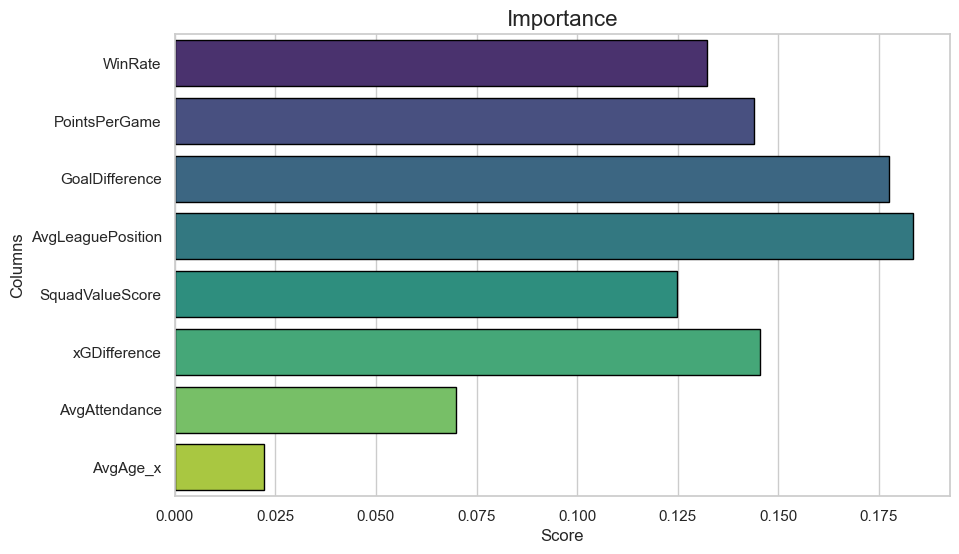

In [ ]:
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances,
    y=imp_cols,
    palette="viridis",
    edgecolor="black"
)
plt.title("Importance", fontsize=16)
plt.xlabel("Score")
plt.ylabel("Columns")
plt.savefig("../Outputs/feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()


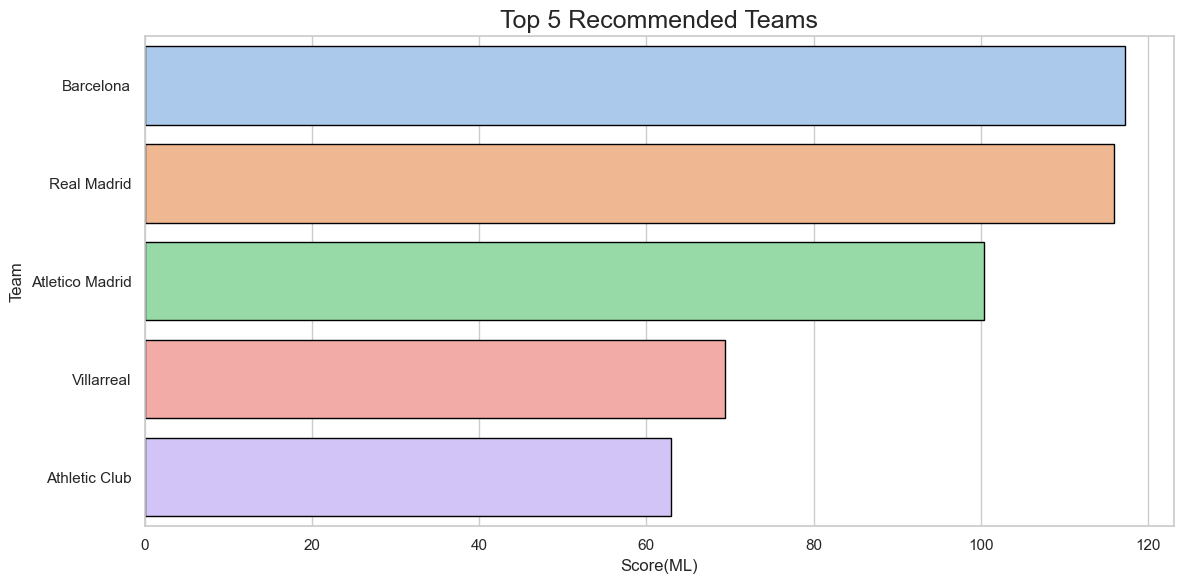

In [ ]:
top5 = ml_score.head(5)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top5,
    x="MLScore",
    y="Team",
    hue="Team",
    palette="pastel",
    edgecolor="black",
)
plt.title("Top 5 Recommended Teams", fontsize=18)
plt.xlabel("Score(ML)")
plt.ylabel("Team")
plt.tight_layout()
plt.savefig("../Outputs/top5_ml_recommendations.png", dpi=300, bbox_inches="tight")
plt.show()


## Key Findings
**Top 3:** Barcelona → Real Madrid → Atlético Madrid

**Most Important Feature:** AvgLeaguePosition (historical consistency predicts better than current form)

**Model Performance:** R² = 0.985 | RMSE = 2.73

---

## Investment

Strong Buy
- MLScore: > 90
- Risk: Low

- MLScore: 70-90
- Risk: Medium

- MLScore: 50-70
- Risk: High
